## Supervised Link Prediction with the Armed Conflict Location Event Database
In this notebook, I will be turning relational data from the Armed Conflict Location & Event Data Project and turning it into several "Conflict" Undirected Graphs/Networks.

The nodes in these graphs will be different "agents" in Afghanistan defined as the product of an actor type and the country that they operate 

The edges in these graphs will be defined as follows: 1 if there was at least one conflict during a time period between two agents and 0 otherwise. The time periods will be different months spanning January 2017 - April 2022.

By using various link prediction/topological features measures, I will create features about the edges that exist and don't exist within these graphs and I shall set my target (what I am trying to predict) as whether or not a conflict occured (represented as an edge existing within the conflict graph) within a certain time frame (a month) ACLED (Armed Conflict Location & Event Data Project) is a disaggregated conflict analysis and crisis mapping project. ACLED collects and analyzes data on locations, dates and types of all reported armed conflict and protest events in developing countries. It can be found here: https://www.acleddata.com/

NOTE: This analysis has only been completed for Afghanistan


In [3]:

import sys
from collections import OrderedDict
from itertools import product
from functools import reduce
import pandas as pd
import time
#present = True
import numpy as np
import re
from networkx import Graph
from functools import reduce, lru_cache
import networkx as nx
from joblib import dump, load
from sklearn.utils import resample
from itertools import product
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score

### Data Cleaning Functions

In [4]:
def load_data(path):
    data = pd.read_csv(path, index_col="data_id")
    data["event_date"] = pd.to_datetime(data["event_date"])
    return data


def load_interaction_codes(path):
    data = pd.read_csv(path)
    return data


### Data Reading Functions

In [5]:
def rename_category_columns(actor_category_df):
    return actor_category_df\
        .rename(columns={'Category_x': 'actor1_category'})\
        .rename(columns={'Category_y': 'actor2_category'})


def get_actor_categories(conflict_df, interaction_lookup):
    actor_category_df = conflict_df.copy
    actor_category_df = conflict_df\
                            .merge(interaction_lookup, 
                                   left_on="inter1", 
                                   right_on="code")\
                            .merge(interaction_lookup, 
                                   left_on="inter2", 
                                   right_on="code")
    return rename_category_columns(actor_category_df)


def subset_columns(conflict_df):
    return conflict_df[["event_date",
                        "country",
                        "actor1",
                        "actor1_category",
                        "actor2",
                        "actor2_category"]]


def get_country(string, countries):
    for country in countries:
        if country in string:
            return country

def country_extractor(conflict_df, countries):
    df = conflict_df.copy()
    df["actor1_country_temp"] = df["actor1"]\
        .apply(lambda x: get_country(x, countries))
    df["actor2_country_temp"] = df["actor2"]\
        .apply(lambda x: get_country(x, countries))

    df["actor1_country"] = np.where(df["actor1_country_temp"].isnull(),
                                    df["country"],
                                    df["actor1_country_temp"])

    df["actor2_country"] = np.where(df["actor2_country_temp"].isnull(),
                                    df["country"],
                                    df["actor2_country_temp"])

    return df[["event_date", "country", 
               "actor1", "actor1_country", "actor1_category", 
               "actor2", "actor2_country", "actor2_category"]]


### Feature Engineering Functions

In [6]:
def create_agents(conflict_df):
    df = conflict_df.copy()

    df['agent1'] = df['actor1_category'] + '-' + df['actor1_country']
    df['agent2'] = df['actor2_category'] + '-' + df['actor1_country']

    return df[["event_date", "agent1", "agent2"]]


def get_month(conflict_df):
    df = conflict_df.copy()
    df["period"] = df.event_date.dt.year.astype(str)\
      + "-" + df.event_date.dt.month.astype(str)
    return df


### Conflict Graph Function

In [7]:
class ConflictGraph(Graph):

    """

    A Graph/Network of conflicts within a certain time period

    """

    def __init__(self, categories, countries, period):
        super().__init__()

        self.categories = categories
        self.countries = countries
        self.period = period

    def __sort_tuple(self, tup):

        """

        Return a tuple after sorting a tuple

        The default behaviour of sorted() returns a list

        """

        return tuple(sorted(tup))

    @lru_cache(maxsize=2)
    def __create_all_possible_nodes(self):

        """

        Create all possible nodes in the network via the product of
        the actor categories and the actor countries

        """

        return [(x + '-' + y) for x in self.categories for y in self.countries]

    @lru_cache(maxsize=2)
    def __get_node_countries(self):
        return {x + '-' + y: y for x in self.categories
                for y in self.countries}

    @lru_cache(maxsize=2)
    def __create_all_possible_edges(self):

        """

        Generate all possible conflicts between agents via permutation

        """

        # Get all nodes for each timestep
        all_potential_nodes = self.__create_all_possible_nodes()

        # Create all possible combinations of nodes as tuples
        all_possible_conflicts = ((x, y) for x in all_potential_nodes
                                  for y in all_potential_nodes)

        # Order each tuple
        all_possible_conflicts_ordered = [self.__sort_tuple(edge) for edge
                                          in all_possible_conflicts]
        # Drop duplicate tuples
        all_possible_conflicts_no_dups = set(all_possible_conflicts_ordered)

        # Convert to dataframe
        all_possible_edges = pd.DataFrame(all_possible_conflicts_no_dups)
        all_possible_edges.columns = ['agent1', 'agent2']

        return all_possible_edges

    def __create_edges(self):

        """

        Create the Graph's "positive" edges (to be imported into a nx.Graph)
        Positive meaning that there was a conflict

        Only looks at the first conflict within the data as the target
        is to predict if at least one conflict will happen in the time
        period

        """

        if len(self.conflicts) == 0:
            return []

        edges = self.conflicts.copy()
        edges = edges.groupby(['agent1', 'agent2'])\
                     .first()\
                     .reset_index()

        # Return as list of tuples
        return edges[["agent1", "agent2"]]\
            .to_records(index=False)\
            .tolist()

    @lru_cache(maxsize=12)
    def get_edge_labels(self):

        """

        Create all edge labels, positive and negative

        Caching of 12 previous computations has been implemented

        """

        all_possible_edges = self.__create_all_possible_edges()

        positive_edges = pd.DataFrame(self.__create_edges())
        positive_edges.columns = ["agent1", "agent2"]

        # Edges that exist get a label of 1
        positive_edges["target"] = 1

        # Join on all possible edges, those with no match, get a 0 label
        edges = positive_edges.merge(all_possible_edges,
                                     how="right",
                                     on=["agent1", "agent2"])\
                              .fillna(0)

        edges["period"] = self.period

        return edges

    def get_nodes(self):
        return self.__create_all_possible_nodes()

    def get_edges(self):
        return self.__create_edges()

    def _add_nodes(self):

        """

        Add all possible agents as nodes to the Graph

        """

        nodes = self.__create_all_possible_nodes()
        self.add_nodes_from(nodes)

    def _set_node_attributes(self):
        values = self.__get_node_countries()
        nx.set_node_attributes(self, name='country', values=values)

    def _add_edges(self):

        """

        Add edges (extracted from the conflict dataframe) to
        the Graph

        """

        edges = self.__create_edges()
        if len(edges) == 0:
            pass
        else:
            self.add_edges_from(edges)

    def set_conflicts(self, conflicts):

        """

        Initialise the conflict graph with a dataframe of conflicts
        Add Nodes and Edges to the Graph

        Keyword Arguments:
        conflicts -- A dataframe of ACLED Conflicts

        """

        self.conflicts = conflicts
        self.all_possible_edges = self.__create_all_possible_edges()\
            .to_records(index=False)\
            .tolist()

        self._add_nodes()
        self._set_node_attributes()
        self._add_edges()

    def __set_suffix(self, lag=None):

        """

        Create a suffix to add onto the end of
        a feature column to represent the lag it has
        relative to the target columns

        """

        suffix = ""
        if lag:
            suffix = "_"+str(lag)+"periods_prev"

        return suffix

    def get_preferential_attachment(self, lag=None):

        """

        Extract the preferential attachment scores for all
        possible edges in this graph

        """

        suf = self.__set_suffix(lag)

        metric = nx.preferential_attachment(self, self.all_possible_edges)
        metric_df = pd.DataFrame(metric)
        metric_df.columns = ["agent1", "agent2", "pref_attachment"+suf]
        return metric_df

    def get_resource_allocation(self, lag=None):

        """

        Extract the resource allocation (with community info) 
        scores for all possible edges in this graph

        """

        suf = self.__set_suffix(lag)

        metric = nx.ra_index_soundarajan_hopcroft(self,
                                                  self.all_possible_edges,
                                                  community='country')
        metric_df = pd.DataFrame(metric)
        metric_df.columns = ["agent1", "agent2", "resource_alloc_com"+suf]
        return metric_df

    def get_jaccard_coefficient(self, lag=None):

        """

        Extract the jaccard coefficient
        scores for all possible edges in this graph

        """

        suf = self.__set_suffix(lag)

        metric = nx.jaccard_coefficient(self, self.all_possible_edges)
        metric_df = pd.DataFrame(metric)
        metric_df.columns = ["agent1", "agent2", "jaccard_coef"+suf]
        return metric_df

    @lru_cache(maxsize=24)
    def get_all_metrics(self, lag=None):

        """

        Extract the preferential attachment, resource allocation
        and jaccard coefficient scores for each potential edge.

        Caching of 12 previous computations has been implemented

        Keyword Arguments:
        lag -- A note/flag of how many periods prior to the edge label
        that these features are.

        """

        pref_attachment = self.get_preferential_attachment(lag)
        resource_allocation = self.get_resource_allocation(lag)
        jaccard_coefficient = self.get_jaccard_coefficient(lag)

        metrics = [pref_attachment, resource_allocation, jaccard_coefficient]

        on = ["agent1", "agent2"]

        all_metrics = reduce(
            lambda x, y: pd.merge(x, y, how='inner', on=on), metrics)

        return all_metrics


 ### Load conflict data
 #### The Data Dictionary is as follows:

 **ISO**: A numeric code for each individual country <br>
 **EVENT_ID_CNTY**: An individual event identifier by
 number and country acronym. <br>
 **EVENT_ID_NO_CNTY**: An individual event numeric identifier. <br>
 **EVENT_DATE**: Recorded as Year/Month/Day. <br>
 **YEAR**: The year in which an event took place. <br>
 **TIME_PRECISION**: A numeric code indicating the level of certainty of
 the date coded for the event (1-3). <br>
 **EVENT_TYPE**: The type of event. <br>
 **SUB_EVENT_TYPE**: The type of sub-event. <br>
 **ACTOR1**: A named actor involved in the event. <br>
 **ASSOC_ACTOR_1**: The named actor associated with or identifying with
 ACTOR1 in one specific event. <br>
 **INTER1**: A numeric codeindicating the type of ACTOR1. <br>
 **ACTOR2**: The named actor involved in the event. If a dyadic event,
 there will also be an “Actor 1”. <br>
 **ASSOC_ACTOR_2**: The named actor associated with or identifying with
 ACTOR2 in one specific event. <br>
 **INTER2**: A numeric code indicating the type of ACTOR2. <br>
 **INTERACTION**: A numeric code indicating the interaction between types of
 ACTOR1 and ACTOR2.
 Coded  as  an  interaction  between  actor types, and  recorded as lowest joint
 number. <br>
 **REGION**: The region of the world where the event took place. <br>
 **COUNTRY**: The country in which the event took place. <br>
 **ADMIN1**: The largest sub-national administrative region
 in which the event took place.<br>
 **ADMIN2**: The second largest sub-national administrative region
 in which the event took place. <br>
 **ADMIN3**: The  third largest sub-national administrative region
 in which the event took place. <br>
 **LOCATION**: The location in which the event took place. <br>
 **LATITUDE**: The latitude of the location. <br>
 **LONGITUDE**: The longitude of the location. <br>
 **GEO_PRECISION**: A numeric code indicating the level of certainty of the
 location coded for the event. <br>
 **SOURCE**: The source(s) used to code the event. <br>
 **SOURCE SCALE**: The geographic scale of the sources used to code the event. <br>
 **NOTES**: A short description of the event. <br>
 **FATALITIES**: Number or estimate of fatalities due to event. <br>
 These are frequently different across reports

In [9]:
data = load_data('C:/Users/Owner/OneDrive/Desktop/ACLED/2000-01-01-2022-04-15-Afghanistan.csv')


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62243 entries, 9056716 to 8984306
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   iso               62243 non-null  int64         
 1   event_id_cnty     62243 non-null  object        
 2   event_id_no_cnty  62243 non-null  int64         
 3   event_date        62243 non-null  datetime64[ns]
 4   year              62243 non-null  int64         
 5   time_precision    62243 non-null  int64         
 6   event_type        62243 non-null  object        
 7   sub_event_type    62243 non-null  object        
 8   actor1            62243 non-null  object        
 9   assoc_actor_1     3427 non-null   object        
 10  inter1            62243 non-null  int64         
 11  actor2            60194 non-null  object        
 12  assoc_actor_2     4989 non-null   object        
 13  inter2            62243 non-null  int64         
 14  interaction   

In [11]:
data.head()

,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
data_id,,,,,,,,,,,,,,,,,,,,,
9056716,4,AFG63707,63707,2022-04-08,2022,1,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Afghanistan),NaN,...,Deh Bala,34.0923,70.4690,2,Etilaat e Roz; Shafaqna,National,"On 8 April 2022, a child was killed and his mo...",1,1649776683,AFG
9056717,4,AFG63708,63708,2022-04-08,2022,1,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Afghanistan),NaN,...,Kunduz,36.7290,68.8570,1,Hasht-e Subh; Shafaqna,National,"On 8 April 2022, a power pylon was destroyed i...",0,1649776683,AFG
9057692,4,AFG63695,63695,2022-04-08,2022,1,Battles,Non-state actor overtakes territory,National Resistance Front,NaN,...,Andarab,35.6335,69.2602,2,Hasht-e Subh,National,"On 8 April 2022, NRF fighters clashed with the...",3,1649776686,AFG
9058235,4,AFG63661,63661,2022-04-08,2022,1,Battles,Armed clash,Afghanistan Freedom Front,NaN,...,Baharak,37.0025,70.9066,2,Twitter,New media,"On 8 April 2022, Afghanistan Freedom Front fig...",0,1649776688,AFG
9058242,4,AFG63673,63673,2022-04-08,2022,1,Battles,Armed clash,National Resistance Front,NaN,...,Jabulussaraj,35.1183,69.2378,2,Twitter,New media,"On 8 April 2022, NRF fighters attacked at Tali...",0,1649776688,AFG


 #### Load lookup codes
 The lookup codes for the inter columns to match them to category type
 Each actor has an associated code which represents the type of actor that they are.

In [13]:
interaction_lookup = load_interaction_codes('C:/Users/owner/OneDrive/Desktop/ACLED/categorycodes.csv')

In [14]:
interaction_lookup

,code,Category
0,1,State Forces
1,2,Rebel Groups
2,3,Political Militias
3,4,Identity Militias
4,5,Rioters
5,6,Protesters
6,7,Civilians
7,8,External/Other Forces


 #### Determine the set of all countries in the data set

In [15]:
countries = set(data.country)

 #### Define all of the possible actor countries

In [16]:
categories = list(interaction_lookup.Category)

## Create a "conflict dataframe"
 Join the interaction lookup to each actor code in order to get the category
 of actor that they are.
 Also, extract the country that each actor belongs from. Conflicts may happen
 in a certain country, but the actors may not come from that country. <br>
 We will be ignoring Associated Actors from this analysis for ease!

In [17]:
conflict_df = data.pipe(lambda x: get_actor_categories(x, interaction_lookup))\
    .pipe(subset_columns)\
    .pipe(lambda x: country_extractor(x, countries))

In [18]:
conflict_df.head()

,event_date,country,actor1,actor1_country,actor1_category,actor2,actor2_country,actor2_category
0,2022-04-08,Afghanistan,Unidentified Armed Group (Afghanistan),Afghanistan,Political Militias,Civilians (Afghanistan),Afghanistan,Civilians
1,2022-04-06,Afghanistan,Unidentified Armed Group (Afghanistan),Afghanistan,Political Militias,Civilians (Afghanistan),Afghanistan,Civilians
2,2022-04-05,Afghanistan,Unidentified Armed Group (Afghanistan),Afghanistan,Political Militias,Civilians (Afghanistan),Afghanistan,Civilians
3,2022-04-03,Afghanistan,Unidentified Armed Group (Afghanistan),Afghanistan,Political Militias,Civilians (Afghanistan),Afghanistan,Civilians
4,2022-04-01,Afghanistan,Unidentified Armed Group (Afghanistan),Afghanistan,Political Militias,Civilians (Afghanistan),Afghanistan,Civilians


## Create a dataframe of all realised conflicts between "Agents"
 This will be a dataframe of all conflicts have actually happened.
 We define an agent as a composite label encompassing an actor's
 country of origin and the actor category.
 This is to ensure that the network has the same amount of nodes

In [19]:
all_realised_conflicts = conflict_df.pipe(create_agents)\
    .pipe(get_month)

In [20]:
all_realised_conflicts.head()

,event_date,agent1,agent2,period
0,2022-04-08,Political Militias-Afghanistan,Civilians-Afghanistan,2022-4
1,2022-04-06,Political Militias-Afghanistan,Civilians-Afghanistan,2022-4
2,2022-04-05,Political Militias-Afghanistan,Civilians-Afghanistan,2022-4
3,2022-04-03,Political Militias-Afghanistan,Civilians-Afghanistan,2022-4
4,2022-04-01,Political Militias-Afghanistan,Civilians-Afghanistan,2022-4


 Define a range of monthly time periods

In [21]:
periods = [str(x)+"-"+str(y) for x, y in
           product(range(2017, 2022), range(1, 13))]

 ## Create Conflict Graphs
 For each time period, create a Conflict Graph with the conflicts that
 happened and didn't happen during that period.

In [22]:
def make_conflict_graphs(all_realised_conflicts, categories,
                         countries, periods):

    """

    For each time period, create a Conflict Graph with the conflicts that
    happened and didn't happen during that period

    """
    conflict_graphs = OrderedDict()
    counter = 0

    print('Creating Conflict Graphs....')

    for period in periods:
        counter += 1

        if counter % 20 == 0:
            print(str(counter) + " out of " + str(len(periods)))

        conflicts = all_realised_conflicts[
            all_realised_conflicts.period == period]

        cf = ConflictGraph(categories=categories,
                           countries=countries,
                           period=period)

        cf.set_conflicts(conflicts)
        conflict_graphs[period] = cf
    
    print('Conflict Graph Creation Complete')

    return conflict_graphs

 Let's see what metrics have been included by taking a sample
 graph

In [23]:
conflicts_2017_1 = all_realised_conflicts[
    all_realised_conflicts.period == '2017-1']

cf = ConflictGraph(categories=categories,
                   countries=countries,
                   period='0217-1')

cf.set_conflicts(conflicts_2017_1)

 We have extracted the jaccard coefficient, resource allocation and
 preferential attachment of each potential edge! (the product of all agents)

In [24]:
cf.get_all_metrics()\
    .sort_values('pref_attachment', ascending=False)\
    .head()

,agent1,agent2,pref_attachment,resource_alloc_com,jaccard_coef
5,State Forces-Afghanistan,State Forces-Afghanistan,49,1.809524,0.833333
32,Rebel Groups-Afghanistan,Rebel Groups-Afghanistan,49,1.809524,0.833333
17,Rebel Groups-Afghanistan,State Forces-Afghanistan,49,0.666667,0.428571
9,Political Militias-Afghanistan,State Forces-Afghanistan,42,0.642857,0.500000
24,Political Militias-Afghanistan,Rebel Groups-Afghanistan,42,0.642857,0.500000


 Lets see what the target dataframe looks like

In [25]:
cf.get_edge_labels()\
    .sort_values('target', ascending=False)\
    .head()

,agent1,agent2,target,period
33,Political Militias-Afghanistan,Political Militias-Afghanistan,1.0,0217-1
32,Rebel Groups-Afghanistan,Rebel Groups-Afghanistan,1.0,0217-1
5,State Forces-Afghanistan,State Forces-Afghanistan,1.0,0217-1
17,Rebel Groups-Afghanistan,State Forces-Afghanistan,1.0,0217-1
30,Protesters-Afghanistan,State Forces-Afghanistan,1.0,0217-1


 ## Explanation of the Features that will be extracted
 $$\Gamma(x) \text{ : The neighbours of the node x. In other words, the nodes that x is connected to.} $$
 $$\left |\Gamma(x)\right| \text{: The size of the neighbour set of x} $$
 $$ \Gamma(x) \cap \Gamma(y) \text{: The shared neighbours of x and y} $$

 The toplogical features we will be extracting for each edge are as follows: <br>

 ##### Resource Allocation Index with Community Information (Soundarajan_hopcroft):

 $$\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{f(w)}{|\Gamma(w)|} \text{ where } f(w) = 1 \text{ if } w \text{ is in the same community as } u \text{ and } w \text{ and } 0 \text{ otherwise}$$

 ##### Jaccard Coefficient:

 $$\frac{\left| \Gamma(x)\cap\Gamma(y) \right|}{\left| \Gamma(x)\cup\Gamma(y) \right|} \text{ for the edge } (x, y)$$

 ##### Preferential Attachment
 $$\left| \Gamma(x) \right| \times \left| \Gamma(y) \right| \text{ for the edge } (x, y)$$

In [ ]:
del data, conflict_df

 # Feature Extraction
 The aim is: <br>
 For each 1 month window of time where conflicts have happened,
 we will extract a dataframe where the target is whether or not a
 conflict/edge existed during that time frame and we will extract the features
 are link prediction measures about the emerging graphs
 (a representation of all the interaction between agents up to a certain time)
 up to 10 months
 in the past in 1 month windows

In [26]:
def full_merge(features, target):

    """

    Merge the dataframes with the link features to the
    link target (absence/presence)

    """

    result = reduce(
        lambda x, y: x.merge(y, on=["agent1", "agent2"]),
        features)
    result = result.merge(target, on=["agent1", "agent2"])
    return result

In [27]:
def make_training_data(graphs, n_prev=12):

    """

    Implement a sliding window approach for extracting features
    and targets

    Example:
    {G1, G2, .... G12} -> G13
    {G2, G3, .... G13} -> G14

    Keyword Arguments:
    graphs -- a dictionary of Conflict Graphs
    n_prev -- The amount of time periods to slide the window
              by


    """

    keys = list(graphs.keys())
    indexes = range(len(graphs)-n_prev)

    train_dfs = []

    start = time.time()

    print('Creating Training Data...')
    for index in indexes:

        if index % 10 == 0:
            print(str(index) + " out of " + str(len(indexes)))
            print(str(time.time() - start) + " seconds elapsed")

        # Select n_prev graphs in a sliding window for feature extraction
        selected_keys_X = keys[index:index+n_prev][::-1]
        # Select a graph with a period 1 after the final graph chosen in
        # selected_keys_X
        selected_keys_Y = keys[index+n_prev]

        # Extract features/metrics for each period selected in
        # selected_keys_X
        features = (graphs[key].get_all_metrics(lag=idx+1)
                    for (idx, key) in enumerate(selected_keys_X))

        # Get the target labels for a graph 1 time period after the
        # features
        target = graphs[selected_keys_Y].get_edge_labels()

        # Merge
        result = full_merge(features, target)

        train_dfs.append(result)

        del features, target, result, selected_keys_X, selected_keys_Y

    print('Training Data Created!')

    return train_dfs

 # Creation of the Training Data via Graph Feature Extraction
 1. Create all of the conflict graphs from 2017-1 to 2022-4
 2. Apply a sliding window approach to get the edge labels for a certain period
 and then the graph features for the previous 12 periods
 3. Concatenate the output from all of the sliding windows
 4. Save as a parquet for the modelling phase

In [28]:
conflict_graphs = make_conflict_graphs(all_realised_conflicts,
                                           categories,
                                           countries,
                                           periods)
train = make_training_data(conflict_graphs)
train_df = pd.concat(train, ignore_index=True)
train_df.to_parquet('df.parquet.gzip', compression='gzip')

Creating Conflict Graphs....
20 out of 60
40 out of 60
60 out of 60
Conflict Graph Creation Complete
Creating Training Data...
0 out of 48
0.0 seconds elapsed
10 out of 48
1.5636804103851318 seconds elapsed
20 out of 48
3.1591691970825195 seconds elapsed
30 out of 48
4.86944842338562 seconds elapsed
40 out of 48
6.3122546672821045 seconds elapsed
Training Data Created!


In [29]:
train_df = pd.read_parquet('df.parquet.gzip')
train_df.head()


,agent1,agent2,pref_attachment_1periods_prev,resource_alloc_com_1periods_prev,jaccard_coef_1periods_prev,pref_attachment_2periods_prev,resource_alloc_com_2periods_prev,jaccard_coef_2periods_prev,pref_attachment_3periods_prev,resource_alloc_com_3periods_prev,...,resource_alloc_com_10periods_prev,jaccard_coef_10periods_prev,pref_attachment_11periods_prev,resource_alloc_com_11periods_prev,jaccard_coef_11periods_prev,pref_attachment_12periods_prev,resource_alloc_com_12periods_prev,jaccard_coef_12periods_prev,target,period
0,Civilians-Afghanistan,Rioters-Afghanistan,0,0.000000,0.00,0,0.000000,0.000000,0,0.000000,...,0.000000,0.0,4,0.142857,0.25,4,0.142857,0.25,0.0,2018-1
1,Civilians-Afghanistan,Rebel Groups-Afghanistan,24,0.642857,0.60,32,0.583333,0.428571,24,0.583333,...,0.700000,0.5,24,0.559524,0.60,28,0.559524,0.50,0.0,2018-1
2,Protesters-Afghanistan,Protesters-Afghanistan,4,0.309524,1.00,1,0.125000,1.000000,0,0.000000,...,0.000000,0.0,0,0.000000,0.00,1,0.142857,1.00,0.0,2018-1
3,External/Other Forces-Afghanistan,Protesters-Afghanistan,6,0.142857,0.25,4,0.125000,0.250000,0,0.000000,...,0.000000,0.0,0,0.000000,0.00,4,0.142857,0.25,0.0,2018-1
4,External/Other Forces-Afghanistan,External/Other Forces-Afghanistan,9,0.559524,1.00,16,0.708333,1.000000,16,0.750000,...,0.559524,1.0,16,0.726190,1.00,16,0.702381,1.00,1.0,2018-1


 # Read in training data
 From feature engineering phase

In [30]:
mode = 'read'
train_df = pd.read_parquet('df.parquet.gzip')

 ## Define the time periods of interest

In [31]:
periods = [str(x)+"-"+str(y) for x, y in
           product(range(2017, 2022), range(1, 13))]

 ## Set the test/train split
 2017-1 - 2019-6 as Train <br>
 2019-7 - 2022-12 as Test

In [32]:
training_range = periods[:48]
testing_range = periods[48:60]
train_flag = train_df.period.isin(training_range)
test_flag = train_df.period.isin(testing_range)

In [33]:
print('Creating Test/Train Splits')
train = train_df[train_flag]
test = train_df[test_flag]

Creating Test/Train Splits


In [34]:
print('Splitting Data')
X_train = train.drop('target', axis=1)\
    .set_index(["agent1", "agent2", "period"])
y_train = train\
    .set_index(["agent1", "agent2", "period"])\
    .loc[:, "target"]

X_test = test.drop('target', axis=1)\
    .set_index(["agent1", "agent2", "period"])
y_test = test\
    .set_index(["agent1", "agent2", "period"])\
    .loc[:, "target"]
print('Complete')

Splitting Data
Complete


 # Model Training
 Here we shall be using a Balanced Random Forest from the imbalanced-learn package.
 A regular random forest takes random subsamples of the data when constructing each tree but
 a balanced random forest creates a subsample by upsampling the minority class.

In [35]:
rf = BalancedRandomForestClassifier(n_jobs=5, verbose=10,
                                        n_estimators=150, random_state=123)
rf.fit(X_train, y_train)
dump(rf, 'model.joblib')

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s


building tree 4 of 150building tree 2 of 150

building tree 1 of 150building tree 3 of 150

building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 11 of 150
building tree 10 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 16 of 150
building tree 15 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 28 of 150
building tree 27 of 150building tree 29 of 150

building tree 30 of 150
building tree 31 of 150
building tree 33 of 150
building tree 32 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 38 of 150
building tree 37 of 150
building tree 39 of 150
building tree 40 of 150
building tree 42 of 150
building tree 41 of 150
b

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.3s


building tree 81 of 150
building tree 80 of 150

building tree 83 of 150building tree 82 of 150

building tree 86 of 150building tree 84 of 150building tree 85 of 150


building tree 87 of 150
building tree 88 of 150
building tree 89 of 150
building tree 90 of 150
building tree 91 of 150
building tree 92 of 150building tree 93 of 150

building tree 94 of 150
building tree 95 of 150
building tree 96 of 150
building tree 98 of 150
building tree 97 of 150
building tree 99 of 150
building tree 100 of 150
building tree 101 of 150
building tree 102 of 150
building tree 103 of 150
building tree 105 of 150
building tree 104 of 150
building tree 107 of 150building tree 106 of 150

building tree 108 of 150
building tree 109 of 150
building tree 110 of 150building tree 111 of 150

building tree 112 of 150
building tree 113 of 150
building tree 116 of 150
building tree 114 of 150
building tree 115 of 150
building tree 117 of 150
building tree 118 of 150
building tree 120 of 150

[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.5s



building tree 121 of 150
building tree 119 of 150
building tree 122 of 150
building tree 125 of 150
building tree 123 of 150
building tree 124 of 150
building tree 126 of 150
building tree 127 of 150
building tree 129 of 150
building tree 128 of 150
building tree 130 of 150building tree 132 of 150

building tree 131 of 150
building tree 133 of 150
building tree 134 of 150
building tree 136 of 150
building tree 135 of 150
building tree 139 of 150
building tree 138 of 150
building tree 137 of 150
building tree 140 of 150
building tree 142 of 150
building tree 141 of 150
building tree 143 of 150
building tree 145 of 150
building tree 144 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 150 of 150
building tree 149 of 150


[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 150 out of 150 | elapsed:    0.6s finished


['model.joblib']

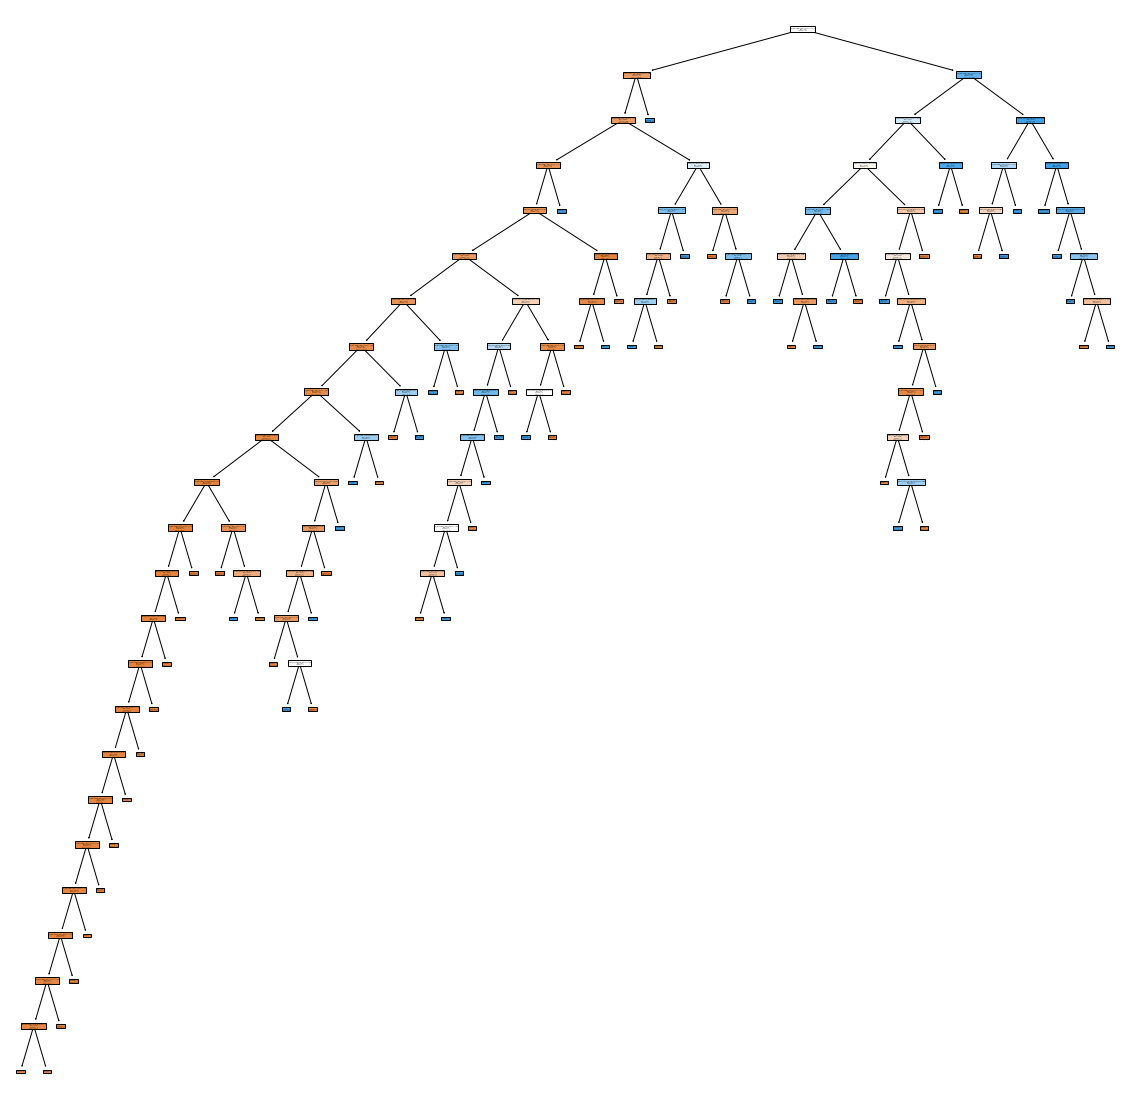

In [36]:
from matplotlib import pyplot as plt
from sklearn import tree
plt.rcParams.update({'figure.figsize': (24.0, 16.0)})
plt.rcParams.update({'font.size': 28})

plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf.estimators_[0], feature_names=X_train.columns, filled=True)

In [37]:
rf.estimators_[0].tree_.max_depth

23

In [38]:
rf = BalancedRandomForestClassifier(n_jobs=5, verbose=10,
                                        n_estimators=150, random_state=123, max_depth=3)
rf.fit(X_train, y_train)


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s


building tree 1 of 150
building tree 5 of 150
building tree 2 of 150
building tree 4 of 150
building tree 3 of 150
building tree 6 of 150
building tree 7 of 150
building tree 9 of 150
building tree 8 of 150
building tree 11 of 150building tree 12 of 150building tree 10 of 150


building tree 13 of 150
building tree 14 of 150
building tree 16 of 150building tree 15 of 150

building tree 17 of 150
building tree 19 of 150
building tree 18 of 150
building tree 20 of 150
building tree 21 of 150
building tree 23 of 150
building tree 22 of 150
building tree 24 of 150
building tree 25 of 150building tree 26 of 150building tree 27 of 150


building tree 29 of 150
building tree 28 of 150
building tree 30 of 150
building tree 31 of 150building tree 32 of 150

building tree 33 of 150
building tree 34 of 150
building tree 36 of 150
building tree 35 of 150building tree 39 of 150

building tree 37 of 150
building tree 38 of 150
building tree 40 of 150
building tree 42 of 150
building tree 41 of 150
b

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.3s



building tree 67 of 150
building tree 66 of 150
building tree 69 of 150
building tree 68 of 150
building tree 70 of 150
building tree 71 of 150
building tree 73 of 150
building tree 72 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150building tree 80 of 150

building tree 81 of 150
building tree 83 of 150
building tree 82 of 150
building tree 85 of 150
building tree 84 of 150
building tree 88 of 150
building tree 86 of 150
building tree 87 of 150
building tree 89 of 150
building tree 90 of 150
building tree 91 of 150
building tree 94 of 150
building tree 92 of 150
building tree 93 of 150
building tree 95 of 150
building tree 96 of 150
building tree 97 of 150
building tree 99 of 150
building tree 98 of 150
building tree 100 of 150

[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.5s



building tree 101 of 150
building tree 102 of 150
building tree 103 of 150
building tree 104 of 150
building tree 105 of 150
building tree 106 of 150
building tree 107 of 150
building tree 108 of 150
building tree 109 of 150
building tree 110 of 150
building tree 111 of 150
building tree 112 of 150
building tree 114 of 150
building tree 113 of 150
building tree 115 of 150
building tree 116 of 150
building tree 117 of 150
building tree 118 of 150
building tree 120 of 150
building tree 121 of 150
building tree 119 of 150
building tree 122 of 150
building tree 125 of 150
building tree 126 of 150
building tree 123 of 150
building tree 124 of 150
building tree 128 of 150
building tree 127 of 150
building tree 130 of 150
building tree 129 of 150
building tree 132 of 150
building tree 131 of 150
building tree 133 of 150
building tree 134 of 150
building tree 135 of 150
building tree 137 of 150
building tree 138 of 150
building tree 136 of 150
building tree 139 of 150
building tree 140 of 150

[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 150 out of 150 | elapsed:    0.7s finished


BalancedRandomForestClassifier(max_depth=3, n_estimators=150, n_jobs=5,
                               random_state=123, verbose=10)

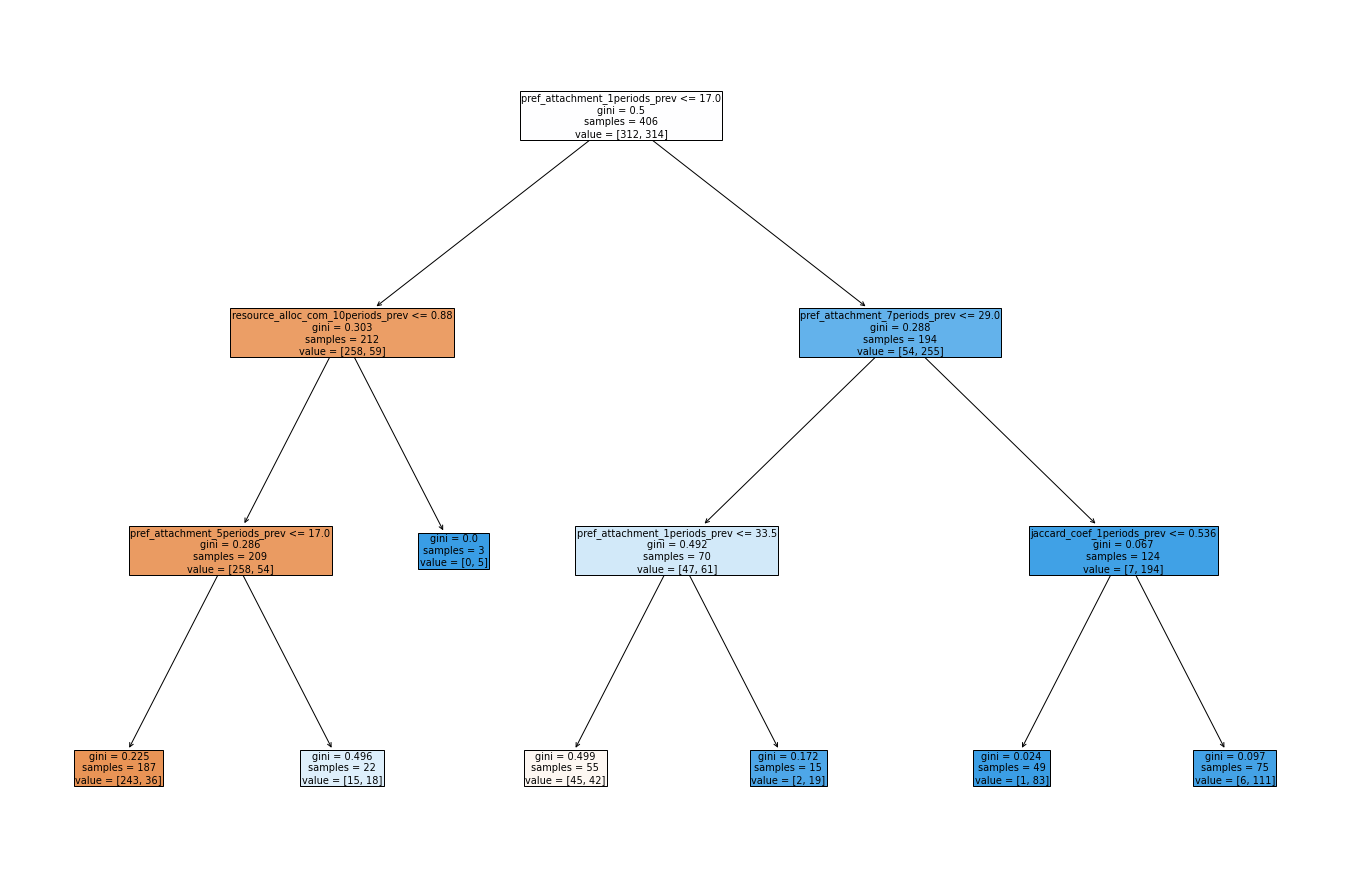

In [39]:
_ = tree.plot_tree(rf.estimators_[0], feature_names=X_train.columns, filled=True)

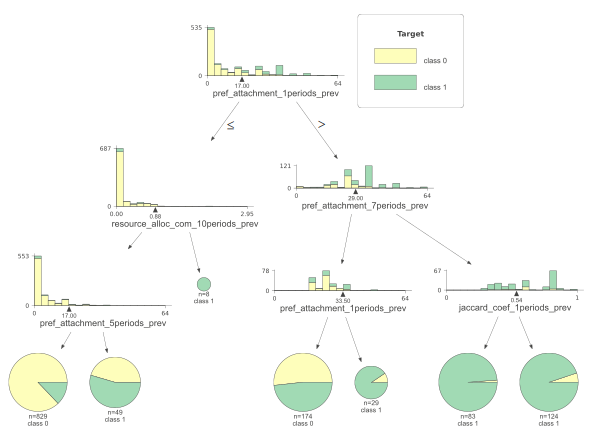

In [40]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(rf.estimators_[0], X_train, y_train, feature_names=X_train.columns, target_name="Target")
viz

In [41]:
rf = load('model.joblib')

 # Model performance
 This is a very very imbalanced dataset, so accuracy shouldn't be the metric of
 overall performance.
 Accuracy doesn't tell us enough about false positives or false negatives (independently).
 We shall choose the metric of interest as recall. This is because (for example) a
 UN agent would be more concerned about false negatives than false positives. People could
 die if you get false negatives!

 # Performance on Training data

In [42]:
y_train_pred = rf.predict(X_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 150 out of 150 | elapsed:    0.0s finished


 #### Confusion Matrix

In [43]:
print(confusion_matrix(y_train, y_train_pred))

[[939  44]
 [  1 312]]


In [44]:
print("Recall Score (TRAIN): " + str(recall_score(y_train, y_train_pred)))
print("F1 (TRAIN): " + str(f1_score(y_train, y_train_pred)))

Recall Score (TRAIN): 0.9968051118210862
F1 (TRAIN): 0.9327354260089685


 # Performance on Testing data

In [45]:
y_test_pred = rf.predict(X_test)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 150 out of 150 | elapsed:    0.0s finished


 #### Confusion Matrix

In [46]:
print(confusion_matrix(y_test, y_test_pred))

[[302  34]
 [ 21  75]]


In [47]:
print("Recall Score (TEST): " + str(recall_score(y_test, y_test_pred)))
print("F1 (TEST): " + str(f1_score(y_test, y_test_pred)))

Recall Score (TEST): 0.78125
F1 (TEST): 0.7317073170731707


 # Feature Importances

In [48]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
cols = list(X_train.columns)
# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(str(f + 1)+'. Feature: '+ cols[indices[f]] + ' '+ str(importances[indices[f]]))

Feature ranking:
1. Feature: pref_attachment_8periods_prev 0.08959808644807969
2. Feature: pref_attachment_10periods_prev 0.07697559416216347
3. Feature: pref_attachment_12periods_prev 0.07383986248319202
4. Feature: pref_attachment_2periods_prev 0.07109929392749408
5. Feature: pref_attachment_7periods_prev 0.06086473374251281
6. Feature: pref_attachment_11periods_prev 0.046827267922086926
7. Feature: pref_attachment_5periods_prev 0.04039928508454296
8. Feature: pref_attachment_3periods_prev 0.04001833806570783
9. Feature: pref_attachment_6periods_prev 0.03994990194121388
10. Feature: pref_attachment_4periods_prev 0.03859693419278863
11. Feature: pref_attachment_9periods_prev 0.03549597560846898
12. Feature: resource_alloc_com_8periods_prev 0.031039374660002415
13. Feature: pref_attachment_1periods_prev 0.029228131324195078
14. Feature: resource_alloc_com_3periods_prev 0.029134690604573615
15. Feature: resource_alloc_com_1periods_prev 0.028095595535293012
16. Feature: resource_alloc_co